In [1]:
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision

In [2]:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

## Get data

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
# !wget https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/raw/master/emitter_segmentation_data.zip
# !unzip microcontroller_segmentation_data.zip
# !ls

In [3]:
cd "/content/drive/My Drive/tower_detection/"

/content/drive/My Drive/tower_detection


In [4]:
pwd

'/content/drive/My Drive/tower_detection'

In [5]:
!ls 'emitter_Segmentation'

test  train


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_emitter_dicts(directory):
    classes = ['tower']
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 600
        record["width"] = 800
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts



In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("emitter_" + d, lambda d=d: get_emitter_dicts('emitter_Segmentation/' + d))
    MetadataCatalog.get("emitter_" + d).set(thing_classes=['tower'])
emitter_metadata = MetadataCatalog.get("emitter_train")

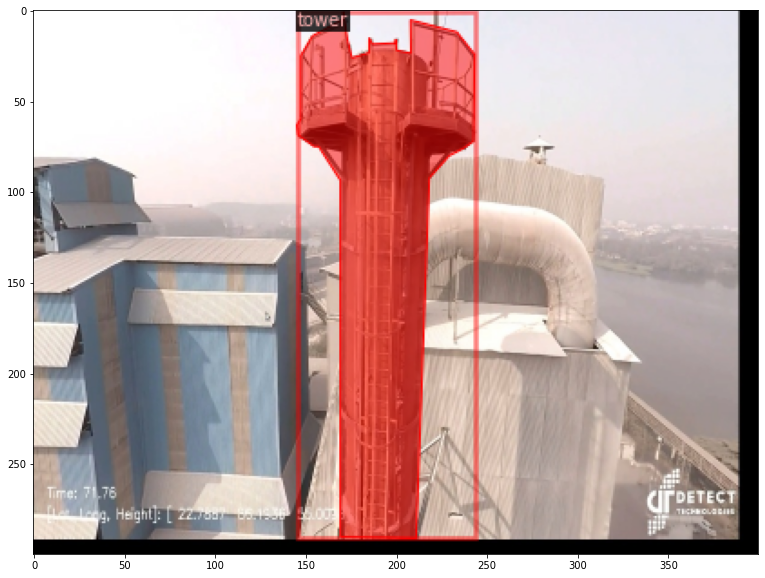

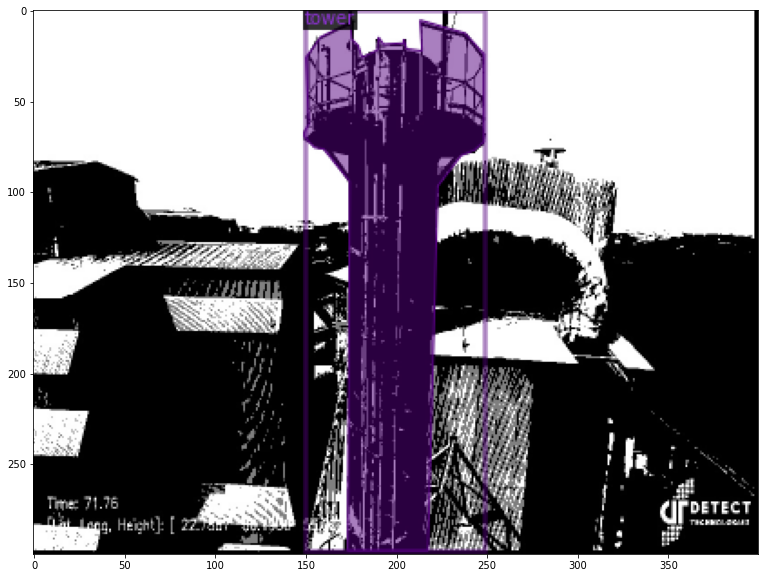

In [8]:
import random
import cv2
dataset_dicts = get_emitter_dicts("emitter_Segmentation/train")
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=emitter_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the emitter data-set.

In [18]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("emitter_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[09/13 10:00:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [ ]:
trainer.train()

[09/13 10:00:53 d2.engine.train_loop]: Starting training from iteration 0
[09/13 10:00:59 d2.utils.events]:  eta: 0:49:31  iter: 19  total_loss: 1.431  loss_cls: 0.640  loss_box_reg: 0.083  loss_mask: 0.696  loss_rpn_cls: 0.003  loss_rpn_loc: 0.009  time: 0.2983  data_time: 0.0132  lr: 0.000005  max_mem: 1606M
[09/13 10:01:06 d2.utils.events]:  eta: 0:50:05  iter: 39  total_loss: 1.326  loss_cls: 0.539  loss_box_reg: 0.074  loss_mask: 0.694  loss_rpn_cls: 0.004  loss_rpn_loc: 0.009  time: 0.3005  data_time: 0.0024  lr: 0.000010  max_mem: 1606M
[09/13 10:01:12 d2.utils.events]:  eta: 0:50:00  iter: 59  total_loss: 1.194  loss_cls: 0.401  loss_box_reg: 0.081  loss_mask: 0.686  loss_rpn_cls: 0.008  loss_rpn_loc: 0.009  time: 0.2995  data_time: 0.0023  lr: 0.000015  max_mem: 1606M
[09/13 10:01:18 d2.utils.events]:  eta: 0:50:14  iter: 79  total_loss: 1.052  loss_cls: 0.264  loss_box_reg: 0.081  loss_mask: 0.675  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.2998  data_time: 0.0027  lr:

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [12]:
print('output directory of model is  ',cfg.OUTPUT_DIR, "model_final.pth")

output directory of model is   ./output model_final.pth


In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("emitter_test", )
predictor = DefaultPredictor(cfg)

In [17]:
emitter_metadata

Metadata(name='emitter_train', thing_classes=['tower'])

(600, 800)


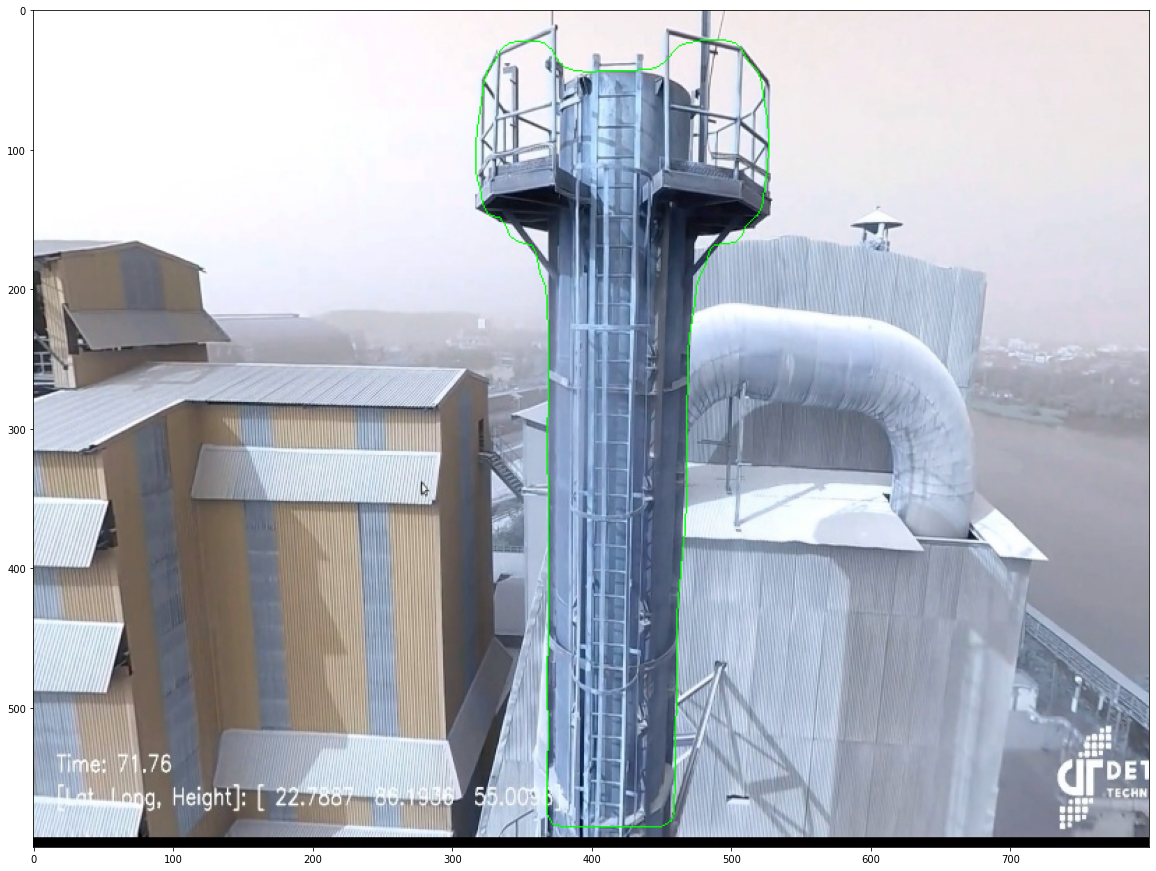

In [16]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_emitter_dicts('emitter_Segmentation/test')
for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    #print(dir(outputs['instances'].__str__))
    # print(outputs.pred_masks)
    v = Visualizer(im[:, :, ::-1],
                   metadata=emitter_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.SEGMENTATION # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    x = outputs["instances"].to("cpu")
    masks = np.asarray(x.pred_masks)
    tower_mask = masks[0]
    tower_mask = tower_mask*255
    print(tower_mask.shape)
    cv2.imwrite("tower_mask.png", tower_mask)
    mask = cv2.imread("tower_mask.png")
    #mask = tower_mask
    #plt.imshow(mask)
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # gray = tower_mask
    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(im, [c], -1, (0, 255, 0), thickness=1)
    plt.figure(figsize=(20,30))
    plt.imshow(im)
    